In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax 
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import arviz as az


import numpyro
from numpyro import distributions as dist, infer

import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Warming up! 

I don't know how to use NumPyro yet. So lets first to a simple line regression problem to get warmed up with the mechanics!

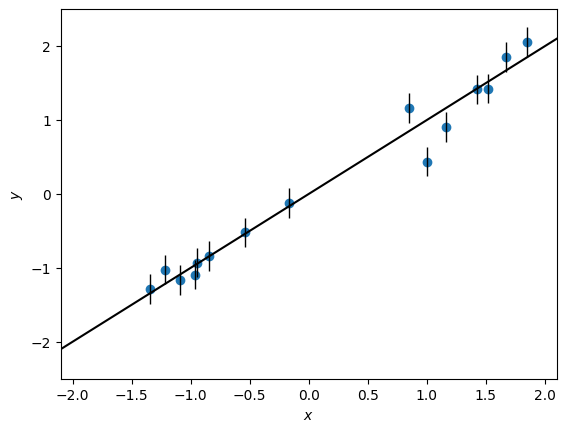

In [2]:
# The linear model has unit slope and zero intercept:
true_params = [1.0, 0.0]



x = np.sort(np.random.uniform(-2, 2, 15))
yerr = 0.2 * np.ones_like(x)
y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))


# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)


def plot_data():
    plt.scatter(x, y)
    plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    plt.plot(x0, y0, color="k", lw=1.5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.ylim(-2.5, 2.5)
    plt.xlim(-2.1, 2.1)


plot_data()


In [3]:

def linear_model(x, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    a = numpyro.sample("a", dist.Uniform(0.0, 5.0)) 
    b = numpyro.sample("b", dist.Uniform(0.0, 5.0))

    # # Transformed parameters (and other things!) can be tracked during sampling using
    # # "deterministics" as follows:
    # m = numpyro.deterministic("m", jnp.tan(theta))
    # b = numpyro.deterministic("b", b_perp / jnp.cos(theta))

    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(a * x + b, yerr), obs=y)


In [4]:
sampler = infer.MCMC(
    infer.NUTS(linear_model),
    num_warmup=200,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)


sampler.run(jax.random.key(0), x, yerr, y=y)

  0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

The NumPyro exit is compatible with the Arviz library for analysing the chains!

In [5]:
import arviz as az

inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.984,0.044,0.898,1.066,0.001,0.001,1191.0,1242.0,1.0
b,0.040,0.031,0.000,0.098,0.001,0.001,1338.0,1082.0,1.0


# Defining artificial data

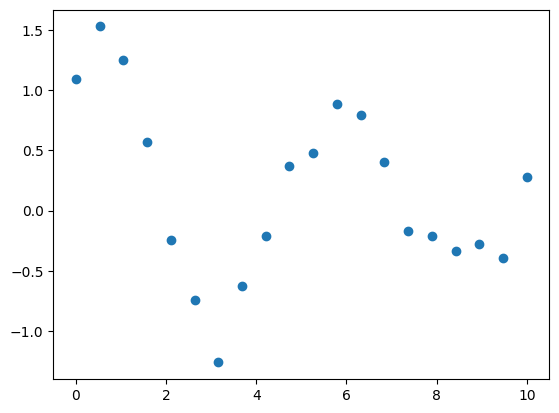

In [6]:
key = jax.random.key(42)
SIGMA = 0.2

initial_cond = (1.1, 1.2)
x0, v0 = initial_cond

def damped_oscillator_scipy(X, t, beta, k):
    x, v = X
    dxdt = v
    dvdt = -beta * v - k * x
    return [dxdt, dvdt]

ts = np.linspace(0, 10, 20)

beta = 0.3
k = 1.5

solution = odeint(damped_oscillator_scipy, initial_cond, ts, args=(beta, k))


ts = jnp.array(ts)
ys = jnp.array(solution[:, 0])
ys = ys + SIGMA*jax.random.normal(key, shape=ys.shape)

plt.scatter(ts, ys)

# Loading DeepONet

In [7]:
from typing import Callable

class DeepOnet(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self, 
        in_branch: int,
        in_trunk: int,
        width: int,
        depth: int,
        interact: int,
        activation: Callable,
        *,
        key
    ):
        """
        Simplified deeponet using twin hidden architectures
        """

        b_key, t_key = jax.random.split(key)

        self.branch_net = eqx.nn.MLP(
            in_branch,
            interact,
            width,
            depth,
            activation,
            key=b_key
        )

        self.trunk_net = eqx.nn.MLP(
            in_trunk,
            interact,
            width,
            depth,
            activation,
            final_activation=activation,
            key=b_key
        )

        self.bias = jnp.zeros((1,))

    
    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """

        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)

        inner_product = jnp.sum(branch_out*trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]


deeponet = DeepOnet(
    4,
    1,
    64,
    6,
    32,
    activation=jax.nn.relu,
    key=jax.random.key(463)
)
        
deeponet = eqx.tree_deserialise_leaves("best_model.eqx", deeponet)

# Defining NumPyro Model

Let's now use NumPyro model definition language to define our model! Rembembering our parameters are $(k, \beta, x_0, v_0)$. Let's again just define their priors over a uniform grid on the parameter space on which the model was trained on!

In [8]:
def probabilistic_model(x, yerr, y=None):

    k = numpyro.sample("k", dist.Uniform(0.0, 5.0)) 
    beta = numpyro.sample("beta", dist.Uniform(0.0, 5.0))
    x0 = numpyro.sample("x0", dist.Uniform(0.0, 5.0))
    v0 = numpyro.sample("v0", dist.Uniform(0.0, 5.0))

    out = jax.vmap(deeponet, in_axes=(None, 0))(jnp.array([k, beta, x0, v0]), x.reshape(-1, 1))

    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(out, yerr), obs=y)

In [33]:
sampler = infer.MCMC(
    infer.NUTS(probabilistic_model),
    num_warmup=100,
    num_samples=10_000,
    num_chains=2,
    progress_bar=True,
)


sampler.run(jax.random.key(0), ts, SIGMA, y=ys)

  0%|          | 0/10100 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

In [36]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.29      0.06      0.28      0.21      0.39   7474.76      1.00
         k      1.47      0.08      1.48      1.34      1.60   6560.47      1.00
        v0      1.25      0.27      1.24      0.83      1.70   6834.69      1.00
        x0      1.15      0.16      1.15      0.90      1.41   6994.29      1.00

Number of divergences: 0


In [39]:
sampler.get_extra_fields()

{'diverging': Array([False, False, False, ..., False, False, False], dtype=bool)}

In [28]:
labels = ["   k", "beta", "  x0", "  v0"]
flat_samples = np.array([sampler.get_samples()[l.strip()] for l in labels]).T


fitted  = flat_samples.mean(axis=0).tolist()
ref_vals = [k, beta, x0, v0]

print("Reference Vals vs Fitted Values\n")

for fit, ref, par in zip(fitted, ref_vals, labels):
    print(f"{par} - ref: {ref:5.2f} - fit: {fit:5.2f}")

Reference Vals vs Fitted Values

   k - ref:  1.50 - fit:  1.47
beta - ref:  0.30 - fit:  0.29
  x0 - ref:  1.10 - fit:  1.15
  v0 - ref:  1.20 - fit:  1.25


In [17]:
flat_samples

array([[1.3229285 , 0.24230418, 1.295749  , 0.946925  ],
       [1.4413892 , 0.39744473, 1.3533702 , 0.93172765],
       [1.4059521 , 0.39943498, 1.4237803 , 1.016423  ],
       ...,
       [1.4790922 , 0.22537908, 0.89778996, 1.3120054 ],
       [1.5117372 , 0.23975664, 0.9576881 , 1.3049271 ],
       [1.5443085 , 0.22595452, 0.94231415, 1.4108683 ]],
      shape=(20000, 4), dtype=float32)

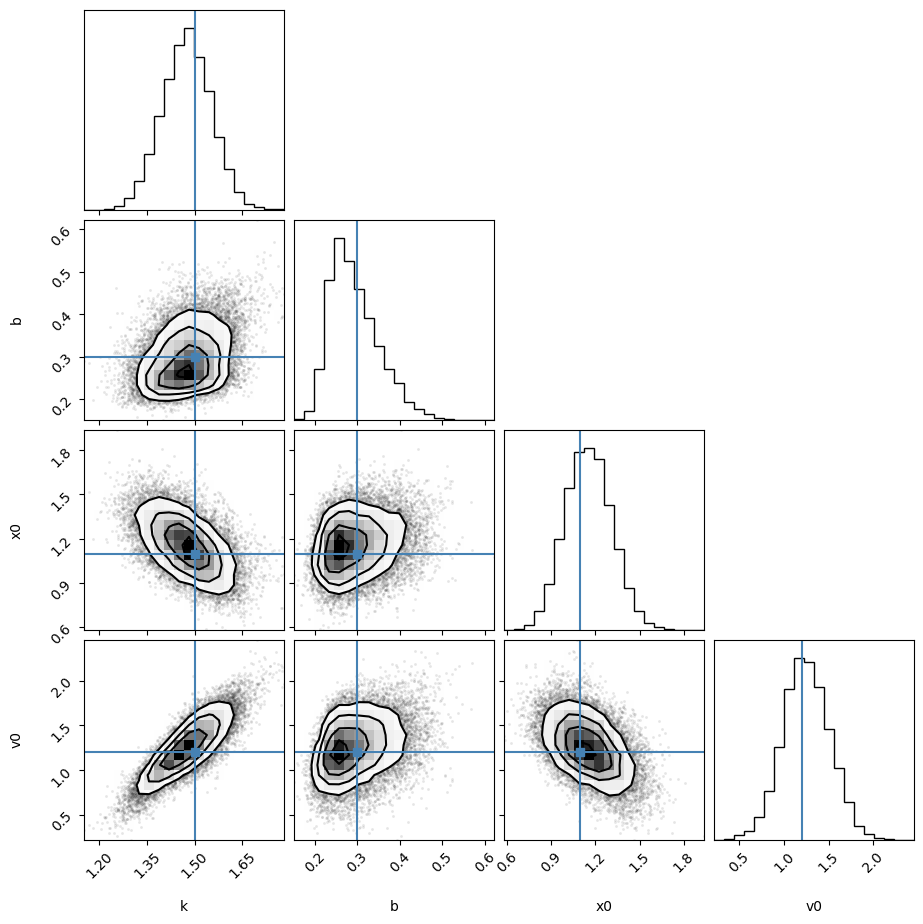

In [29]:
import corner

labels = ["k", "b", "x0", "v0"]

fig = corner.corner(
    flat_samples, labels=labels, truths=ref_vals
);

# ArViz analysis

In [30]:
idata_hmc = az.from_numpyro(sampler)

idata = idata_hmc

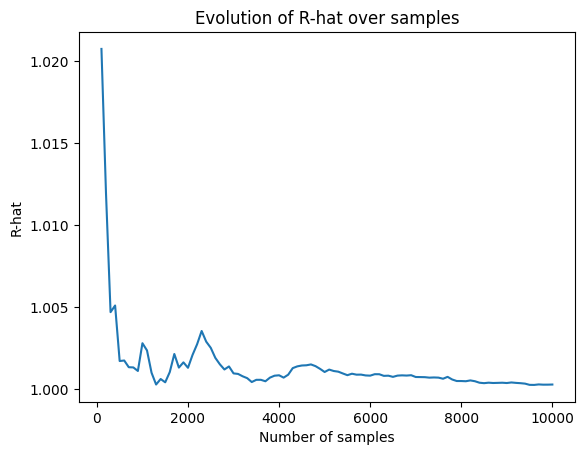

In [31]:
# Suppose you have your inference data (posterior samples) in 'idata'
# and want to calculate R-hat in progressive chunks

# Number of samples per chunk
chunk_size = 100
num_samples = idata.posterior.sizes["draw"]
rhat_values = []

for i in range(chunk_size, num_samples + 1, chunk_size):
    # Slice the samples up to i-th sample
    partial_idata = idata.sel(draw=slice(0, i))
    # Compute R-hat for this subset
    rhat = az.rhat(partial_idata)
    # Average R-hat over parameters (or select specific parameter)
    rhat_mean = rhat.to_array().mean().item()
    rhat_values.append(rhat_mean)

# Plot evolution
plt.plot(range(chunk_size, num_samples + 1, chunk_size), rhat_values)
plt.xlabel("Number of samples")
plt.ylabel("R-hat")
plt.title("Evolution of R-hat over samples")
plt.show()


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'x0'}>]],
      dtype=object)

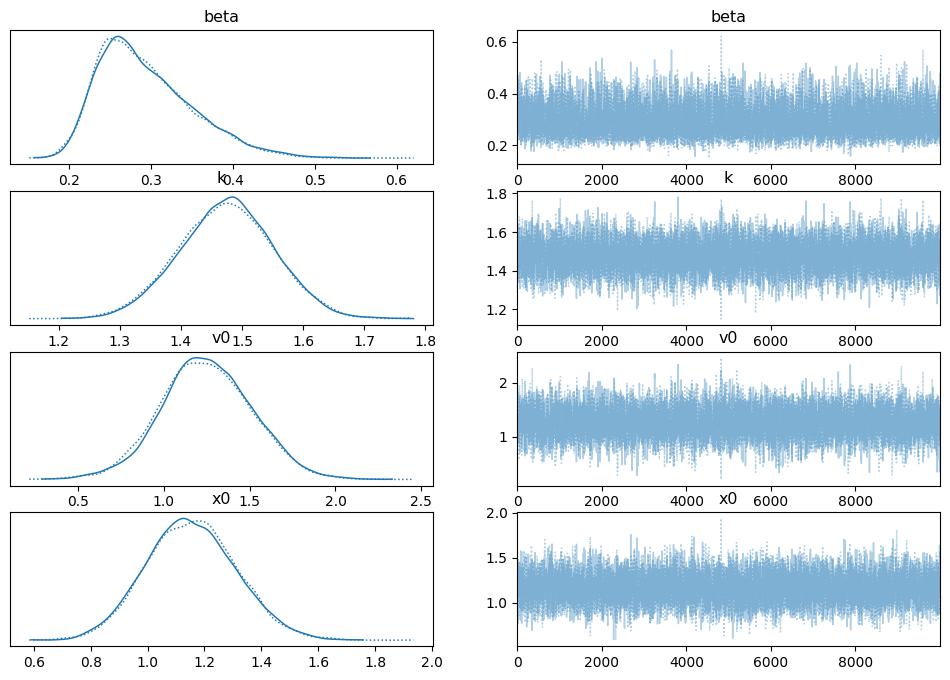

In [35]:
az.plot_trace(idata)

In [34]:
idata.to_netcdf("../../outputs/inference_data_numpyro.nc")

'../../outputs/inference_data_numpyro.nc'